In [1]:
import numpy as np
import datetime as dt
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import cartopy

from pynextsim.gridding import Grid
import mod_netcdf_utils as mnu

from compare_rs2_moorings import(
    get_arg_parser,
    read_rs2_file,
    compare,
    NS_PROJ,
    TrajectoryGenerator,
)

In [2]:
mfil = '/docker_io/arktalas/Moorings.nc'
rfil = '/docker_io/arktalas/pm_20130224T023841Z-20130225T020927Z_21.npz'
args = get_arg_parser().parse_args([rfil, mfil, 'comp_rs2_moorings'])
print(vars(args))

{'rs2_file': '/docker_io/arktalas/pm_20130224T023841Z-20130225T020927Z_21.npz', 'moorings_file': '/docker_io/arktalas/Moorings.nc', 'outdir': 'comp_rs2_moorings'}


In [3]:
dto1, dto2, pm_results, xy1, gpi_rs2 = read_rs2_file(rfil)
nci = mnu.nc_getinfo(mfil)
tg = TrajectoryGenerator(nci, NS_PROJ, xy1, expansion_factor=3)
tg0 = TrajectoryGenerator(nci, NS_PROJ, xy1, expansion_factor=1.1)
grid = tg.get_grid()
grid0 = tg0.get_grid()

Reading                 : /docker_io/arktalas/pm_20130224T023841Z-20130225T020927Z_21.npz
Start                   : 2013-02-24 02:38:41
End                     : 2013-02-25 02:09:27
Interval                : 23:30:46
Number of drift vectors : 1224


In [4]:
for k,v in pm_results.items():
    print(k, v.shape)

lon1pm (50, 53)
lat1pm (50, 53)
upm (50, 53)
vpm (50, 53)
apm (50, 53)
rpm (50, 53)
hpm (50, 53)
lon2pm (50, 53)
lat2pm (50, 53)
hh (9833, 10546)
upm_clean (50, 53)
vpm_clean (50, 53)


In [5]:
print(xy1[0].min(), xy1[0].max())
print(tg.x.min(), tg.x.max())

-1777900.5546218774 -1287563.7230074462
-2243420.260903216 -778420.2379921342


## Check `time_iterator`

In [6]:
def test_time_iterator(tg, dto1, dto2):
    t1 = dto1
    for i, dt_ in tg.time_iterator(dto1, dto2):
        t2 = t1 + dt.timedelta(seconds=dt_)
        print(i, tg.nci.datetimes[i], t1, t2, sep=' | ')
        t1 = t2

In [7]:
test_time_iterator(tg, dto1, dto2)

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 03:00:00
89 | 2013-02-24 04:30:00 | 2013-02-24 03:00:00 | 2013-02-24 06:00:00
90 | 2013-02-24 07:30:00 | 2013-02-24 06:00:00 | 2013-02-24 09:00:00
91 | 2013-02-24 10:30:00 | 2013-02-24 09:00:00 | 2013-02-24 12:00:00
92 | 2013-02-24 13:30:00 | 2013-02-24 12:00:00 | 2013-02-24 15:00:00
93 | 2013-02-24 16:30:00 | 2013-02-24 15:00:00 | 2013-02-24 18:00:00
94 | 2013-02-24 19:30:00 | 2013-02-24 18:00:00 | 2013-02-24 21:00:00
95 | 2013-02-24 22:30:00 | 2013-02-24 21:00:00 | 2013-02-25 00:00:00
96 | 2013-02-25 01:30:00 | 2013-02-25 00:00:00 | 2013-02-25 02:09:27


In [8]:
test_time_iterator(tg, dto1, dto1 + dt.timedelta(minutes=1))

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 02:39:41


In [9]:
test_time_iterator(tg, dto1, dt.datetime(2013,2,24,3))

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 03:00:00


In [10]:
test_time_iterator(tg, dto1, dt.datetime(2013,2,24,3,1))

88 | 2013-02-24 01:30:00 | 2013-02-24 02:38:41 | 2013-02-24 03:00:00
89 | 2013-02-24 04:30:00 | 2013-02-24 03:00:00 | 2013-02-24 03:01:00


## Check interpolation
Interpolate onto in-between grid points

In [11]:
i0, i1, j0, j1 = tg.ij_range
x_target = .5*(tg.x[1:] + tg.x[:-1])
y_target = .5*(tg.y[1:] + tg.y[:-1])
x_target, y_target = np.meshgrid(x_target, y_target)
shp = x_target.shape
dst_p = np.array([y_target.flatten(), x_target.flatten()]).T
grid2 = Grid(x_target, y_target, projection=NS_PROJ)

Text(0.5, 1.0, 'u, m/s')

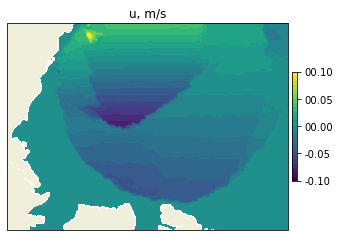

In [12]:
time_index = 88
idata = dict(
    siu=tg.nci.get_var('siu', time_index=time_index, ij_range=tg.ij_range).values.filled(np.nan),
    siv=tg.nci.get_var('siv', time_index=time_index, ij_range=tg.ij_range).values.filled(np.nan),
    )
idata = tg.get_interpolated_vars(idata, dst_p)
fix, ax = grid2.plot(idata['siu'].reshape(shp), cmap='viridis', clim=[-.1,.1])
ax.set_title('u, m/s')

Actual data

In [13]:
data = []
masks = []
for time_index in [88, 96]:
    data += [{
        k : tg.nci.get_var(k, ij_range=tg.ij_range, time_index=time_index).values
        for k in ['sic', 'sit', 'siu', 'siv']
        }]
    masks += [data[-1]['sic'] < .15 ]
    for k in ['siu', 'siv']:
        data[-1][k][masks[-1]] = np.nan

Text(0.5, 1.0, 'v, m/s')

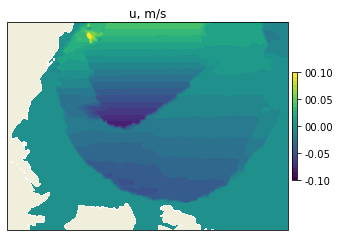

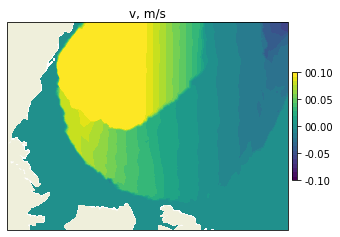

In [14]:
fig, ax = grid.plot(data[0]['siu'], cmap='viridis', clim=[-.1,.1])
ax.set_title('u, m/s')
fig, ax = grid.plot(data[0]['siv'], cmap='viridis', clim=[-.1,.1])
ax.set_title('v, m/s')

## Radarsat2 drift

In [15]:
igi = grid.get_interpolator((pm_results['lon1pm'], pm_results['lat1pm']),
                            latlon=True, interp_from=False)

Projecting external points
Triangulating external points and matching to grid points


Text(0.5, 1.0, 'v, m/s')

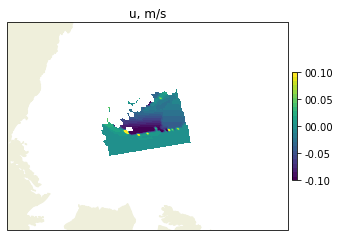

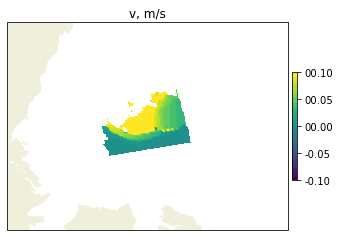

In [16]:
delta_t = (dto2 - dto1).total_seconds()
u_rs2 = igi.interp_field(pm_results['upm_clean']/delta_t)
fig, ax = grid.plot(u_rs2, cmap='viridis', clim=[-.1, .1])
ax.set_title('u, m/s')
# # add model ice edge
# grid.add_contour(ax, data[0]['sic'], levels=[.15], colors='m') #initial edge
# grid.add_contour(ax, data[1]['sic'], levels=[.15], colors='k') #final edge

v_rs2 = igi.interp_field(pm_results['vpm_clean']/delta_t)
fig, ax = grid.plot(v_rs2, cmap='viridis', clim=[-.1, .1])
ax.set_title('v, m/s')
# # add model ice edge
# grid.add_contour(ax, data[0]['sic'], levels=[.15], colors='m') #initial edge
# grid.add_contour(ax, data[1]['sic'], levels=[.15], colors='k') #final edge

## Integrate neXtSIM velocities to give corresponding drift to the Radarsat 2

In [17]:
xt, yt, dtimes, time_indices, sic_av = tg0.integrate_velocities(*xy1, dto1, dto2)
dx_mod = xt[:,-1] - xt[:,0]
dy_mod = yt[:,-1] - yt[:,0]

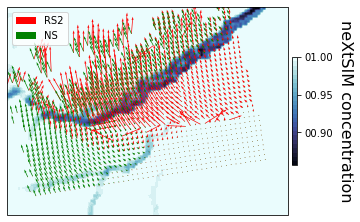

In [18]:
fig, ax = grid0.plot(sic_av, clabel='neXtSIM concentration')
ax.quiver(*xy1, pm_results['upm_clean'][gpi_rs2], pm_results['vpm_clean'][gpi_rs2],
          color='r', units='xy', scale=.5, label='RS2')
ax.quiver(*xy1, dx_mod, dy_mod, color='g', units='xy', scale=.5, label='NS')#, scale='xy')
ax.legend()

In [19]:
bias_speed, rmse_speed, vrmse = compare(dx_mod, dy_mod,
        pm_results['upm_clean'][gpi_rs2], pm_results['vpm_clean'][gpi_rs2],
        delta_t)

Bias in speed = 2.0483679276168196 km/day
RMSE in speed = 5.900897745302216 km/day
VMRSE = 6.496443362680502 km/day


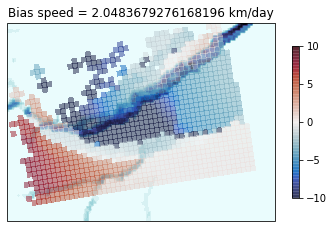

In [20]:
unit_fac = 1e-3*24*3600/delta_t #m -> km/day
spd_diff = np.full_like(pm_results['lon1pm'], np.nan) #m
spd_diff[gpi_rs2] = (
    np.hypot(dx_mod, dy_mod)
    - np.hypot(pm_results['upm_clean'][gpi_rs2], pm_results['vpm_clean'][gpi_rs2])
    )
fig, ax = grid0.plot(sic_av, add_colorbar=False)
x1pm, y1pm = NS_PROJ.pyproj(pm_results['lon1pm'], pm_results['lat1pm'])
spd_diff *= unit_fac #km/day
im = ax.pcolor(x1pm, y1pm, spd_diff, cmap='balance',
               shading='auto', vmin=-10, vmax=10, alpha=0.5)
ax.set_title(f'Bias speed = {bias_speed} km/day')
fig.colorbar(im, shrink=0.7)

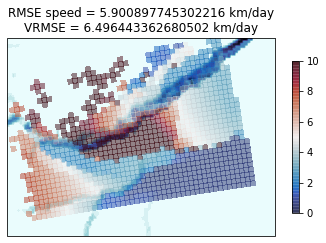

In [21]:
vdiff = np.full_like(pm_results['lon1pm'], np.nan) #m
vdiff[gpi_rs2] = np.hypot(
    dx_mod - pm_results['upm_clean'][gpi_rs2],
    dy_mod - pm_results['vpm_clean'][gpi_rs2],
    )
fig, ax = grid0.plot(sic_av, add_colorbar=False)
vdiff *= unit_fac #km/day
im = ax.pcolor(x1pm, y1pm, vdiff,
               cmap='balance', shading='auto', vmin=0, vmax=10, alpha=0.5)
ax.set_title(f'RMSE speed = {rmse_speed} km/day\nVRMSE = {vrmse} km/day')
fig.colorbar(im, shrink=0.7)

Text(0.5, 1.0, 'r = -0.0002629174228899749')

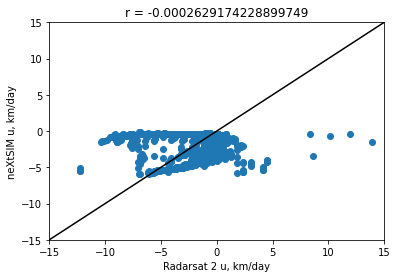

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
uo = pm_results['upm_clean'][gpi_rs2]*unit_fac
inds = np.argsort(uo)
uo = uo[inds]
um = dx_mod[inds]*unit_fac
gpi = np.isfinite(uo*um)

ax.plot(uo, uo, 'k')
ax.scatter(uo, um)
ax.set_xlabel('Radarsat 2 u, km/day')
ax.set_ylabel('neXtSIM u, km/day')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.set_title(f'r = {pearsonr(uo[gpi], um[gpi])[0]}')

Text(0.5, 1.0, 'r = 0.5799091597929107')

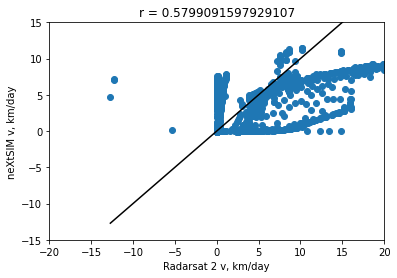

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
vo = pm_results['vpm_clean'][gpi_rs2]*unit_fac
inds = np.argsort(vo)
vo = vo[inds]
vm = dy_mod[inds]*unit_fac
gpi = np.isfinite(vo*vm)

ax.plot(vo, vo, 'k')
ax.scatter(vo, vm)
ax.set_xlabel('Radarsat 2 v, km/day')
ax.set_ylabel('neXtSIM v, km/day')
ax.set_xlim([-20,20])
ax.set_ylim([-15,15])
ax.set_title(f'r = {pearsonr(vo[gpi], vm[gpi])[0]}')